# 22장 시퀀스 배열로 다루는 순환 신경망

## 1. 순환 신경망(RNN)의 기본 개념

순환 신경망(Recurrent Neural Network, RNN)은 시퀀스(sequence) 형태의 데이터를 처리하기 위해 설계된 인공 신경망입니다. 일반적인 피드포워드 신경망과 달리 RNN은 이전 단계의 정보를 기억하고 현재 입력과 함께 처리할 수 있는 '기억'을 가지고 있습니다. 이러한 특성은 자연어 처리, 음성 인식, 시계열 데이터 분석 등 순서가 중요한 데이터를 다룰 때 특히 유용합니다.



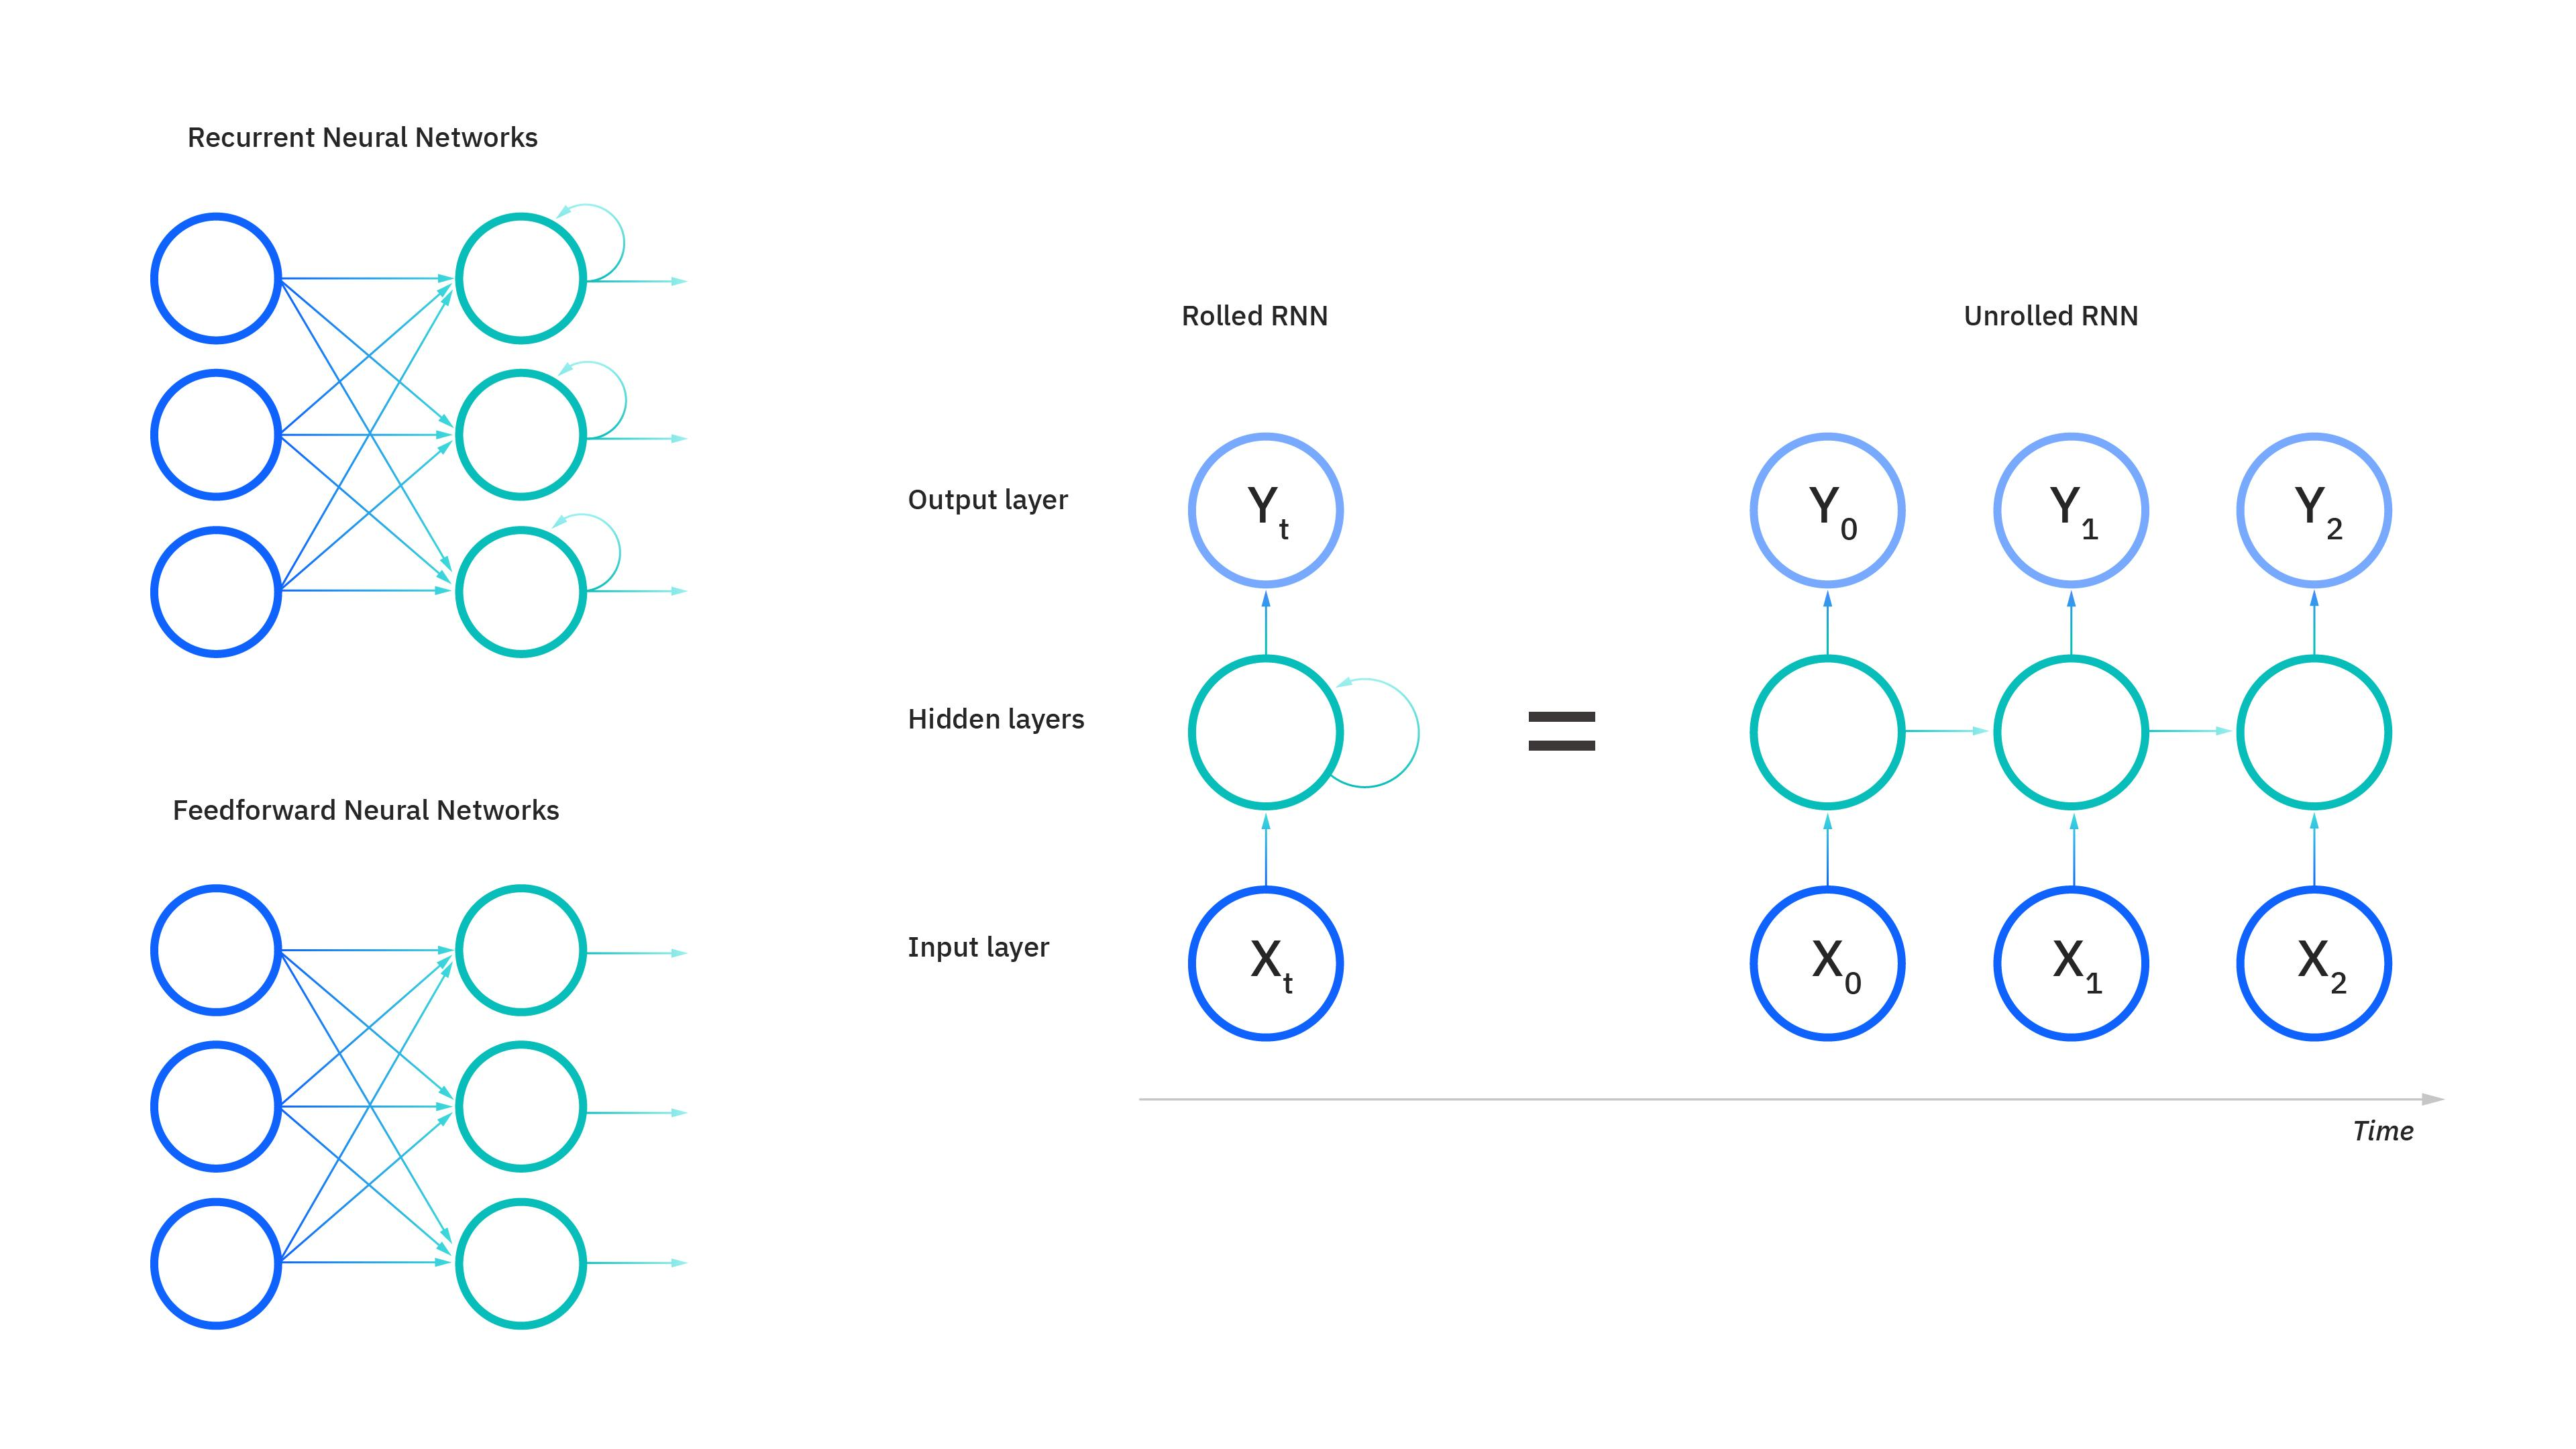



### RNN의 구조적 특징

RNN의 가장 큰 특징은 '순환(recurrent)' 구조입니다. 이 구조에서 네트워크는:
- 현재 입력(x_t)을 받습니다.
- 이전 시점의 은닉 상태(hidden state, h_{t-1})를 함께 처리합니다.
- 새로운 은닉 상태(h_t)를 생성하고, 이를 다음 시점으로 전달합니다.

이 순환 구조는 다음과 같은 수식으로 표현됩니다:
$$ h_t = tanh(W_x·x_t + W_h·h_{t-1} + b) $$
$$ y_t = softmax(W_y·h_t + b_y) $$

여기서:
- $h_t$: 현재 시점의 은닉 상태
- $x_t$: 현재 시점의 입력
- $W_x$, $W_h$, $W_y$: 가중치 행렬
- $b$, $b_y$: 편향(bias)
- tanh, softmax: 활성화 함수




### RNN의 한계와 LSTM의 등장

기본적인 RNN은 '장기 의존성 문제(long-term dependency problem)'라는 한계를 가지고 있습니다. 시퀀스가 길어질수록 초기 정보가 점차 소실되는 문제(기울기 소실 문제)가 발생합니다. 이를 해결하기 위해 LSTM(Long Short-Term Memory)이 개발되었습니다.

## 2. LSTM(Long Short-Term Memory)

LSTM은 RNN의 한 종류로, 장기 의존성 문제를 해결하기 위해 설계되었습니다. LSTM은 기본적인 RNN보다 복잡한 구조를 가지고 있지만, 더 효과적으로 장기 정보를 기억할 수 있습니다.

### LSTM의 구조

LSTM의 핵심은 '셀 상태(cell state)'입니다. 셀 상태는 정보가 변형 없이 흐르는 컨베이어 벨트와 같은 역할을 합니다. LSTM은 이 셀 상태에 정보를 추가하거나 제거하기 위한 세 가지 게이트를 가지고 있습니다:

1. **망각 게이트(forget gate)**: 셀 상태에서 어떤 정보를 버릴지 결정합니다.
2. **입력 게이트(input gate)**: 새로운 정보 중 어떤 것을 셀 상태에 저장할지 결정합니다.
3. **출력 게이트(output gate)**: 셀 상태의 어떤 부분을 출력으로 내보낼지 결정합니다.

이러한 게이트 구조 덕분에 LSTM은 긴 시퀀스에서도 중요한 정보를 효과적으로 기억하고 불필요한 정보는 잊을 수 있습니다.

## 3. 실습: LSTM을 이용한 로이터 뉴스 카테고리 분류하기

이 실습에서는 LSTM을 사용하여 로이터 뉴스 데이터셋의 카테고리를 분류하는 모델을 구현합니다.

![](https://ashutoshtripathi.com/wp-content/uploads/2021/06/rnn-vs-lstm.png)


In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.datasets import reuters       # 로이터 뉴스 데이터셋 불러오기
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
(X_train, y_train), (X_test, y_test) = reuters.load_data(num_words=1000, test_split=0.2)

# 데이터를 확인해 보겠습니다.
category = np.max(y_train) + 1
print(category, '카테고리')
print(len(X_train), '학습용 뉴스 기사')
print(len(X_test), '테스트용 뉴스 기사')
print(X_train[0])

2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
46 카테고리
8982 학습용 뉴스 기사
2246 테스트용 뉴스 기사
[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 2, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 2, 2, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 2, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


### 로이터 뉴스 데이터셋 설명

로이터 뉴스 데이터셋은 총 46개의 카테고리로 분류된 11,228개의 뉴스 기사로 구성되어 있습니다. 이 중 8,982개는 학습용, 2,246개는 테스트용으로 사용됩니다. 각 뉴스 기사는 단어 인덱스의 시퀀스로 표현되는데, 위 코드에서는 빈도수 기준 상위 1,000개의 단어만 사용합니다.

출력된 첫 번째 뉴스 기사(X_train[0])는 단어 인덱스의 배열로, 각 숫자는 특정 단어를 나타냅니다. 이러한 시퀀스 데이터를 LSTM으로 처리하기 위해서는 모든 시퀀스의 길이를 동일하게 맞추는 패딩(padding) 과정이 필요합니다.

### 데이터 전처리 및 모델 구성

In [2]:
# 단어의 수를 맞추어 줍니다.
X_train = sequence.pad_sequences(X_train, maxlen=100)
X_test = sequence.pad_sequences(X_test, maxlen=100)

# 원-핫 인코딩 처리를 합니다.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(1000, 100))
model.add(LSTM(100, activation='tanh'))
model.add(Dense(46, activation='softmax'))

# 모델의 실행 옵션을 정합니다.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 학습의 조기 중단을 설정합니다.
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

# 모델을 실행합니다.
history = model.fit(X_train, y_train, batch_size=20, epochs=200, validation_data=(X_test, y_test), callbacks=[early_stopping_callback])

# 테스트 정확도를 출력합니다.
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, y_test)[1]))

Epoch 1/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 18s 38ms/step - accuracy: 0.4124 - loss: 2.4125 - val_accuracy: 0.5089 - val_loss: 1.9135
Epoch 2/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.5128 - loss: 1.8747 - val_accuracy: 0.5570 - val_loss: 1.7515
Epoch 3/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.5728 - loss: 1.6567 - val_accuracy: 0.5864 - val_loss: 1.6048
Epoch 4/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.6122 - loss: 1.5174 - val_accuracy: 0.6167 - val_loss: 1.5390
Epoch 5/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 12s 26ms/step - accuracy: 0.6616 - loss: 1.3184 - val_accuracy: 0.6447 - val_loss: 1.3868
Epoch 6/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.6851 - loss: 1.2195 - val_accuracy: 0.6732 - val_loss: 1.3030
Epoch 7/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.7153 - loss: 1.1056 - val_accuracy: 0.6968 - val_loss: 1.2228
Epoch 8/200
450/450 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.7471 - loss: 0

### 모델 구성 요소 설명

1. **Embedding 층**: 
   - 각 단어를 100차원의 벡터로 변환합니다.
   - 입력: 1000개의 단어 인덱스
   - 출력: 각 단어에 대한 100차원 벡터

2. **LSTM 층**:
   - 시퀀스 데이터를 처리하는 핵심 층
   - 100개의 유닛을 가지며, tanh 활성화 함수를 사용
   - 순서 정보를 유지하면서 중요한 특성을 추출

3. **Dense 층(출력층)**:
   - 46개의 뉴스 카테고리에 대한 확률 분포를 출력
   - softmax 활성화 함수를 사용하여 다중 클래스 분류 수행

### 학습 과정 시각화

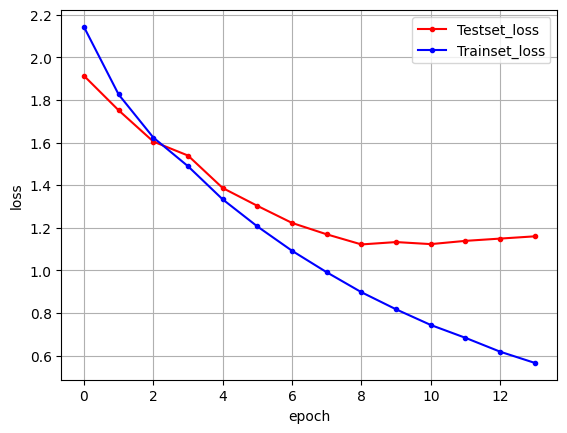

In [3]:
# 학습셋과 테스트셋의 오차를 저장합니다.
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

# 그래프로 표현해 보겠습니다.
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')

# 그래프에 그리드를 주고 레이블을 표시하겠습니다.
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

학습 과정 그래프는 모델이 어떻게 학습되는지 보여줍니다:
- 파란색 선: 학습 데이터에 대한 손실(loss)
- 빨간색 선: 검증 데이터에 대한 손실(loss)

이상적인 학습 과정에서는 두 선 모두 점차 감소하게 됩니다. 만약 학습 데이터의 손실은 계속 감소하지만 검증 데이터의 손실이 증가하기 시작한다면, 이는 과적합(overfitting)의 신호입니다. 이 경우 EarlyStopping 콜백이 학습을 조기 종료합니다.

## 4. LSTM과 CNN의 조합을 이용한 영화 리뷰 분류하기

이 실습에서는 CNN(Convolutional Neural Network)과 LSTM을 결합한 모델을 사용하여 영화 리뷰의 감성(긍정/부정)을 분류합니다.

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Embedding, LSTM, Conv1D, MaxPooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt

# 데이터를 불러와 학습셋, 테스트셋으로 나눕니다.
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=5000)

# 단어의 수를 맞추어 줍니다.
X_train = sequence.pad_sequences(X_train, maxlen=500)
X_test = sequence.pad_sequences(X_test, maxlen=500)

# 모델의 구조를 설정합니다.
model = Sequential()
model.add(Embedding(5000, 100))
model.build((None, 500))
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, padding='valid', activation='relu',strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(55))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.summary()

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 500, 100)       │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 496, 64)        │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 124, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 55)             │        26,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 558,520 (2.13 MB)

 Trainable params: 558,520 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

### CNN과 LSTM 결합 모델의 장점

CNN과 LSTM을 결합하면 두 모델의 장점을 모두 활용할 수 있습니다:

1. **CNN(Convolutional Neural Network)**:
   - 지역적 특성(local feature)을 잘 포착합니다.
   - 텍스트에서는 n-gram과 같은 연속된 단어 패턴을 인식합니다.
   - Conv1D 층은 1차원 합성곱을 수행하여 문장에서 중요한 패턴을 추출합니다.

2. **LSTM(Long Short-Term Memory)**:
   - 장기적인 의존성(long-term dependency)을 포착합니다.
   - CNN이 추출한 특성들 간의 순서 정보를 처리합니다.
   - 문맥 정보를 유지하며 전체 시퀀스의 의미를 파악합니다.

### 모델 구성 요소 상세 설명

1. **Embedding 층(5000, 100)**:
   - 5000개의 단어를 100차원 벡터로 변환합니다.
   - 각 단어의 의미적 특성을 포착합니다.

2. **Dropout(0.5)**:
   - 과적합 방지를 위해 50%의 뉴런을 무작위로 비활성화합니다.

3. **Conv1D(64, 5, ...)**:
   - 64개의 필터를 사용하여 5개 단어 크기의 윈도우로 합성곱을 수행합니다.
   - 'relu' 활성화 함수를 사용하여 비선형성을 추가합니다.

4. **MaxPooling1D(pool_size=4)**:
   - 4개 단위로 최대값을 선택하여 특성 맵의 크기를 줄입니다.
   - 중요한 특성은 유지하면서 연산량을 감소시킵니다.

5. **LSTM(55)**:
   - 55개의 유닛을 가진 LSTM 층이 시퀀스 정보를 처리합니다.
   - CNN이 추출한 지역적 특성들 사이의 관계를 학습합니다.

6. **Dense(1) + Activation('sigmoid')**:
   - 이진 분류(긍정/부정)를 위한 출력층입니다.
   - sigmoid 활성화 함수는 0과 1 사이의 확률값을 출력합니다.

## 5. Seq2Seq 모델과 어텐션 메커니즘

Seq2Seq(Sequence-to-Sequence) 모델은 입력 시퀀스를 다른 형태의 출력 시퀀스로 변환하는 모델입니다. 주로 기계 번역, 텍스트 요약, 챗봇 등에 사용됩니다.

### Seq2Seq 모델의 구조

Seq2Seq 모델은 크게 두 부분으로 구성됩니다:

1. **인코더(Encoder)**:
   - 입력 시퀀스를 받아 고정된 크기의 컨텍스트 벡터로 압축합니다.
   - 보통 RNN이나 LSTM을 사용합니다.

2. **디코더(Decoder)**:
   - 인코더의 컨텍스트 벡터를 받아 출력 시퀀스를 생성합니다.
   - 각 시점에서 이전 출력과 현재 상태를 기반으로 다음 출력을 예측합니다.

### 어텐션 메커니즘(Attention Mechanism)

기본적인 Seq2Seq 모델의 한계는 모든 정보를 하나의 고정된 컨텍스트 벡터에 압축해야 한다는 점입니다. 이로 인해 긴 시퀀스를 처리할 때 정보 손실이 발생합니다.

어텐션 메커니즘은 이 문제를 해결하기 위해 도입되었습니다:

- 디코더가 출력을 생성할 때마다 인코더의 모든 은닉 상태를 참조합니다.
- 현재 디코더 상태와 가장 관련이 높은 인코더 상태에 더 많은 '주의(attention)'를 기울입니다.
- 이를 통해 긴 시퀀스에서도 중요한 정보를 효과적으로 활용할 수 있습니다.

### Seq2Seq 모델 구현 예제

아래 코드는 간단한 Seq2Seq 모델의 구현 예시입니다:

Epoch 1/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step - accuracy: 0.0000e+00 - loss: 4.1064 - val_accuracy: 0.5000 - val_loss: 4.0965
Epoch 2/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7500 - loss: 4.0911 - val_accuracy: 0.5000 - val_loss: 4.0871
Epoch 3/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7500 - loss: 4.0753 - val_accuracy: 0.5000 - val_loss: 4.0769
Epoch 4/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7500 - loss: 4.0582 - val_accuracy: 0.5000 - val_loss: 4.0657
Epoch 5/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7500 - loss: 4.0390 - val_accuracy: 0.5000 - val_loss: 4.0530
Epoch 6/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7500 - loss: 4.0169 - val_accuracy: 0.5000 - val_loss: 4.0383
Epoch 7/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7500 - loss: 3.9910 - val_accuracy: 0.5000 - val_loss: 4.0209
Epoch 8/25
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7500 - loss: 3.9599 - val_accuracy: 0.5000 - val_loss: 4.

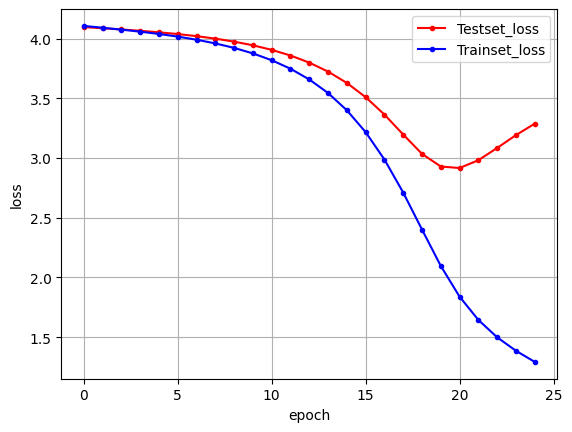

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

# 예제용 데이터셋
# 한국어 입력 (X_data)
# "오늘 날씨 어때"   → [1, 2, 3]
# "오늘 주가 얼마"   → [1, 4, 5]
# "날씨가 점점 따뜻해" → [6, 7, 8]
X_data = [
    [1, 2, 3],
    [1, 4, 5],
    [6, 7, 8]
]

# 영어 출력 (Y_data)
# "It is warm"  → [10, 20, 30]
# "It is high"  → [10, 20, 50]
# "Getting warm" → [60, 30]
Y_data = [
    [10, 20, 30],
    [10, 20, 50],
    [60, 30]
]

# 패딩
X_train = pad_sequences(X_data, maxlen=5)  # 입력 시퀀스를 길이 5로 맞춤
Y_train = pad_sequences(Y_data, maxlen=4)  # 출력 시퀀스를 길이 4로 맞춤

# 입력 단어 집합 크기와 출력 단어 집합 크기 자동 설정
input_vocab_size = np.max(X_train) + 1
output_vocab_size = np.max(Y_train) + 1

# 원-핫 인코딩 (출력 데이터용)
y_train = to_categorical(Y_train, num_classes=output_vocab_size)

# 인코더 정의
encoder_inputs = Input(shape=(5,))
enc_emb = Embedding(input_dim=input_vocab_size, output_dim=64)(encoder_inputs)
encoder_lstm = LSTM(128, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# 디코더 정의
decoder_inputs = Input(shape=(4,))
dec_emb = Embedding(input_dim=output_vocab_size, output_dim=64)(decoder_inputs)
decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
decoder_dense = Dense(output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# 모델 구성
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# 모델 컴파일
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습
history = model.fit([X_train, Y_train], y_train, batch_size=2, epochs=25, validation_split=0.2)

# 학습 과정 시각화
y_vloss = history.history['val_loss']
y_loss = history.history['loss']
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Seq2Seq 모델의 학습 과정

1. **데이터 준비**:
   - 입력 시퀀스와 출력 시퀀스를 동일한 길이로 패딩합니다.
   - 출력 시퀀스는 원-핫 인코딩으로 변환합니다.

2. **인코더-디코더 아키텍처**:
   - 인코더는 입력 시퀀스를 처리하여 상태 벡터(state_h, state_c)를 생성합니다.
   - 디코더는 인코더의 상태를 초기 상태로 사용하여 출력 시퀀스를 생성합니다.
   - `return_state=True` 파라미터는 LSTM 층이 은닉 상태와 셀 상태를 반환하도록 합니다.

3. **모델 학습**:
   - 입력으로 [encoder_inputs, decoder_inputs]를 받습니다.
   - 출력으로 디코더의 예측을 반환합니다.
   - 손실 함수로 'categorical_crossentropy'를 사용합니다.

## 6. RNN의 응용 분야

순환 신경망(RNN)과 그 변형(LSTM, GRU 등)은 다양한 분야에서 활용됩니다:

1. **자연어 처리(NLP)**:
   - 기계 번역(Machine Translation)
   - 텍스트 생성(Text Generation)
   - 감성 분석(Sentiment Analysis)
   - 질의응답 시스템(Question Answering)

2. **음성 인식 및 처리**:
   - 음성을 텍스트로 변환(Speech-to-Text)
   - 음성 명령 인식(Voice Command Recognition)

3. **시계열 데이터 분석**:
   - 주가 예측(Stock Price Prediction)
   - 날씨 예측(Weather Forecasting)
   - 센서 데이터 분석(Sensor Data Analysis)

4. **이미지 캡셔닝(Image Captioning)**:
   - 이미지를 설명하는 텍스트 생성

5. **비디오 분석**:
   - 행동 인식(Action Recognition)
   - 비디오 설명 생성(Video Description)

## 7. 요약 및 결론

순환 신경망(RNN)은 시퀀스 데이터를 처리하는 강력한 도구입니다. 특히 LSTM과 같은 변형 모델은 장기 의존성 문제를 해결하여 긴 시퀀스 데이터에서도 효과적으로 학습할 수 있습니다.

이번 장에서 다룬 내용을 요약하면:

1. RNN의 기본 구조와 작동 원리
2. 장기 의존성 문제와 이를 해결하기 위한 LSTM
3. LSTM을 이용한 텍스트 분류 실습
4. CNN과 LSTM의 조합 모델
5. Seq2Seq 모델과 어텐션 메커니즘

순환 신경망은 계속해서 발전하고 있으며, 특히 Transformer와 같은 새로운 아키텍처가 등장하면서 자연어 처리 분야에서 큰 혁신을 이끌고 있습니다. 그러나 RNN과 LSTM의 기본 원리를 이해하는 것은 여전히 중요하며, 많은 실제 응용 분야에서 이러한 모델들이 활용되고 있습니다.